# DeepDream
"DeepDream" is a convolutional neural network image-modification technique using representations learned by the network. The algorithm consists of running gradient ascent on an input image in order to maximize the activation of an entire convolutional layer. As a result the strongly activated features of an input image are even more strongly activated, resulting in psychedelic visualizations.

To create our DeepDreams, we will be using a convnet pretrained on ImageNet: Inception V3.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
# LOAD PRETRAINED CONVNET
tf.compat.v1.disable_eager_execution()
K.set_learning_phase(0) #Disable training operations

model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False) #Only conv base


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
## SETUP CONFIGURATION / SELECT SET OF LAYERS

# Dict of weighting for the contribution of layers to loss maximization
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.0,
    'mixed4': 2.0,
    'mixed5': 1.5
}


## DEFINE LOSS TO MAXIMIZE
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = 0

for layer_name, coef in layer_contributions.items():
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # add L2 norm of layer activations to loss (exclude border pixels)
    loss += coef * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling
    

In [4]:
## SETUP GRADIENT ASCENT

dream = model.input

grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) #gradient normalization

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    loss_value, grad_values = fetch_loss_and_grads([x])
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at iter', i, 'is:',loss_value)
        x += step * grad_values
    return x

When running gradient ascent on the input image, we start with a small image and successively scale to larger images using a scaling factor. The details lost by scaling to a larger image size are then added back in since we know how the original image should look like.

In [5]:
# Helper functions
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2
    x += 0.5
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
## RUN GRADIENT ASCENT OVER SUCCESSIVE IMAGE SCALING

step = 0.01         #step size for grad asc
num_octave = 3      #number of diff scales
octave_scale = 1.4  #scaling factor
iterations = 20     #number of grad asc iterations per octave

max_loss = 10

#img_path = "Parrot.jpg"
img_path = "Fish.jpg"
img = preprocess_image(img_path)

# List of shape tuples for diff octaves
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[::-1] #Reverse ordering so its increasing

original_img = np.copy(img)
shrunk_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations, step, max_loss)
    upscaled_shrunk_img = resize_img(shrunk_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_img
    
    img += lost_detail #Add lost detail back into upscaled img
    shrunk_img = resize_img(original_img, shape)

Processing image shape (338, 510)
...Loss value at iter 0 is: 2.0294573
...Loss value at iter 1 is: 2.5704482
...Loss value at iter 2 is: 3.4221306
...Loss value at iter 3 is: 4.378918
...Loss value at iter 4 is: 5.2666144
...Loss value at iter 5 is: 6.162203
...Loss value at iter 6 is: 7.005467
...Loss value at iter 7 is: 7.781537
...Loss value at iter 8 is: 8.573682
...Loss value at iter 9 is: 9.306114
Processing image shape (474, 714)
...Loss value at iter 0 is: 3.4287791
...Loss value at iter 1 is: 4.7130494
...Loss value at iter 2 is: 5.851474
...Loss value at iter 3 is: 6.910022
...Loss value at iter 4 is: 7.887409
...Loss value at iter 5 is: 8.777669
...Loss value at iter 6 is: 9.644816
Processing image shape (664, 1000)
...Loss value at iter 0 is: 3.4487753
...Loss value at iter 1 is: 4.6764526
...Loss value at iter 2 is: 5.7703686
...Loss value at iter 3 is: 6.81743
...Loss value at iter 4 is: 7.8097057
...Loss value at iter 5 is: 8.7755165
...Loss value at iter 6 is: 9.694447

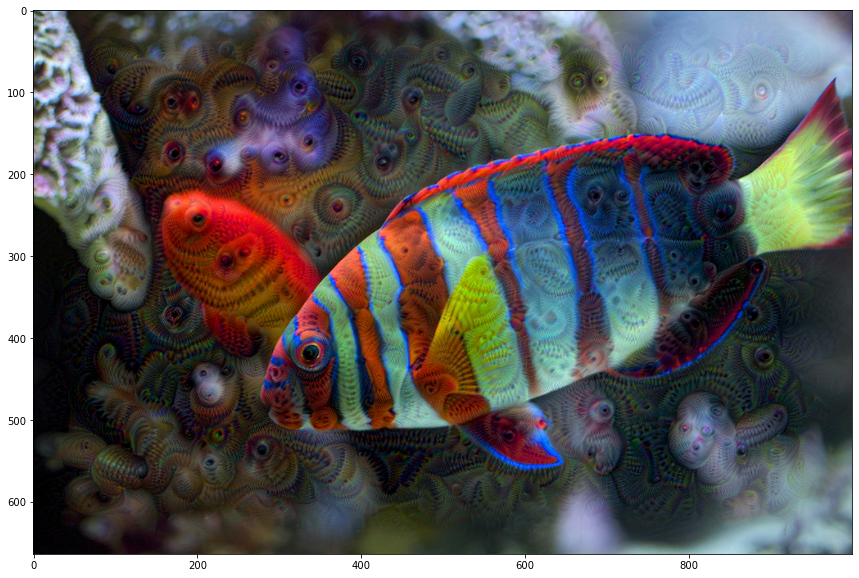

In [7]:
# DISPLAY TRANSFORMED IMAGE

plt.figure(figsize=(15,10))
plt.imshow(deprocess_image(np.copy(img)))
plt.show()